# Overfit and underfit
- Overfitting and underfitting are common phenomenon that can be easily observed when training the model. Overfitting occurs when the model is highly dependent on the train data. On the other hand, underfitting happens when there is still room for improvement on the train data. Therefore, learning how to deal with overfitting and underfitting is important so that the developed model can able to generalize well to a testing set. 
- This tutorial will cover several common regularization techniques as well as preventing overfitting and underfitting to improve a classification model. 
- Full tutorial reference: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

### Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.9.1


### The Higgs dataset

In [2]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [3]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type='GZIP')

In [4]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

In [5]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


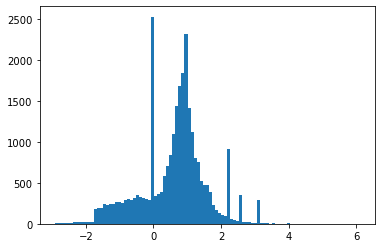

In [6]:
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [7]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [8]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [9]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

### Training procedure
- *tf.keras.optimizers.schedule* to reduce the learning rate over time
- *tfdocs.EpochDots* to reduce the logging noise
- *tf.keras.callbacks.EarlyStopping* to avoid long and unnecessary training times
- *tf.keras.callbacks.TensorBoard* to generate TensorBoard logs for the training

In [10]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001,
                                                             decay_steps=STEPS_PER_EPOCH*1000,
                                                             decay_rate=1,
                                                             staircase=False)
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

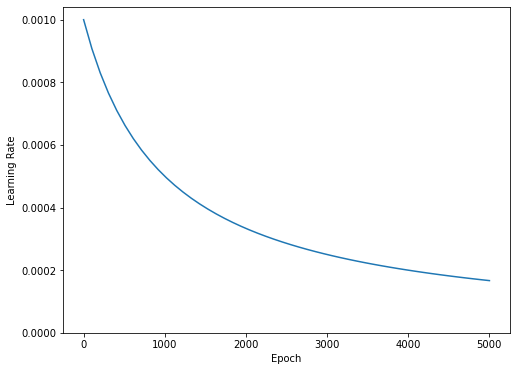

In [11]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

### Pre-defined functions
- Each model in this tutorial will utilize the same training configuration created below

In [12]:
def get_callbacks():
    return [tfdocs.modeling.EpochDots(),
            tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200)]

In [13]:
def compile_and_fit(model, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                  metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'), 'accuracy'])

    model.summary()

    history = model.fit(train_ds,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=max_epochs,
                        validation_data=validate_ds,
                        callbacks=get_callbacks(),
                        verbose=0)
    return history

In [14]:
size_histories = {}

### Tiny model
- The base model that contains a layer with input shape (28, ) and 16 output units, plus one output dense layer.

In [15]:
tiny_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1)
])

size_histories['tiny_model'] = compile_and_fit(tiny_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4735,  binary_crossentropy:1.1680,  loss:1.1680,  val_accuracy:0.4620,  val_binary_crossentropy:0.8886,  val_loss:0.8886,  
....................................................................................................
Epoch: 100, accuracy:0.5812,  binary_crossentropy:0.6341,  loss:0.6341,  val_accuracy:0.5650,  val_binary_crossentropy:0.6352,  val_loss:0.6352,  
............................................................

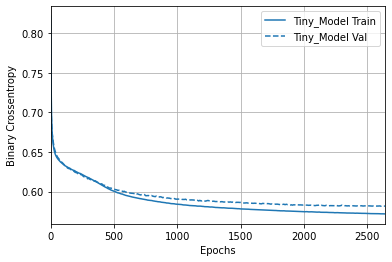

In [16]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)

### Small model
- Small model (larger than the *tiny model*) contains two hidden layers with 16 units each.

In [17]:
small_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(1)
])

size_histories['small_model'] = compile_and_fit(small_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4832,  binary_crossentropy:0.7844,  loss:0.7844,  val_accuracy:0.5000,  val_binary_crossentropy:0.7242,  val_loss:0.7242,  
....................................................................................................
Epoch: 100, accuracy:0.6161,  binary_crossentropy:0.6200,  loss:0.6200,  

### Medium model
- Medium model contains three hidden layers with 64 units each.

In [18]:
medium_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(1)
])

size_histories['medium_model'] = compile_and_fit(medium_model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4964,  binary_crossentropy:0.6937,  loss:0.6937,  val_accuracy:0.4800,  val_binary_crossentropy:0.6786,  val_loss:0.6786,  
....................................

### Large model
- Create even larger model than medium model.

In [19]:
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(1),
])

size_histories['large_model'] = compile_and_fit(large_model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4954,  binary_crossentropy

### Plot the training and validation losses
- Solid lines show the training loss, and the dashed lines show the validation loss (lower validation loss indicates a better model)
- As seen below plot, only the *tiny model* manages to avoid overfitting completely, and each of other models (larger models than *tiny model*) overfit the data more quickly. 
- If the validation metric begins to stagnate while the training metric keeps to improve, or if the validation metric is going in the wrong direction, the model starts overfitting. 

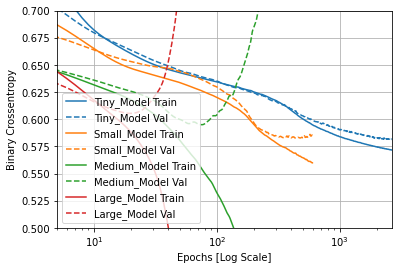

In [20]:
plotter.plot(size_histories)
plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")
plt.show()